# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science

## Table of Contents

* [Introduction/Business Problem](#intro)
* [Installing/Loading Libraries](#installs)
* [Collecting Our Data](#collection)
* [Visualising the Problem](#visualise)
* [Data Wrangling](#wrangle)
* [Clustering Our Data](#cluster)
* [Visualising Our Clusters](#cluster-vis)
* [Concluding Remarks](#conclusion)

## Introduction / Business Problem <a name="intro"></a>

A local business owner is looking to open a new bar in the city of Leeds, the issue is that they are unsure on a specific location in which to open. They also do not know exactly what type of bar to open (e.g. simply a bar, speakeasy, traditional pub, etc.).

They wish to open as soon as possible and have spoken to several stakeholders concerning this task. A stakeholder has suggested using location data to decide upon a suitable location to open the bar. As such, they have reached out to a Data Scientist in order to complete this task.

Leveraging the Foursquare location data API, this report will endeavour to highlight potential areas where it may be profitable to open a bar. It may be the case that a location with few bars surrounding it may be the best fit, however more factors are to be considered. For example, many people do not stay in one bar for an entire night out and as such it may be more profitable to open a bar in a busier area in order to increase foot traffic and subsequent profit.

It completely depends on the type of establishment that is to be opened, so this report will attempt to answer this question. A __clustering approach__ will be taken to segment the different areas around Leeds in order to locate an optimal location to open this business.

## Installing and loading in the appropriate libraries and modules <a name="installs"></a>

In [1]:
# Ensuring these packages are installed before beginning:
# !conda install -c conda-forge geopy --yes
# !conda install -c conda-forge folium=0.5.0 --yes

print("Libraries Installed")

Libraries Installed


#### These are all the packages used in this Notebook

In [2]:
import urllib.request
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np

from geopy.geocoders import Nominatim
import folium

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import requests
from pandas.io.json import json_normalize

## Collecting Our Data <a name="collection"></a>

In [3]:
url = "https://en.wikipedia.org/wiki/LS_postcode_area"

page = urllib.request.urlopen(url)

soup = BeautifulSoup(page, "lxml")

wiki_table = soup.find_all("table")

Unfortunately, the table found within the Wikipedia article was not the easiest to work with and some tweaking was needed to gather the correct information in the correct format.

For example, the first table in the webpage contained information which we did not want, so we had to be sure we were not scraping from this by accident.

As well as this, the data contained in the first column (the postcodes) were denoted as headers within the html code (notice the use of 'th' in order to extract the relevant information in the cell below).

Due to these reasons, it was necessary to create lists Z, A and B separately from each other before combining them all into one DataFrame.

In [4]:
Z=[]

for row in soup.find_all('tr'):
    cells=row.find_all('th')
    if len(cells)==1:
        Z.append(cells[0].find(text=True))

df=pd.DataFrame(Z, columns=['PostCode'])

# The scrape returned more data than was to be expected by simply viewing the webpage, so this is dropped below:
df = df.iloc[8:].reset_index(drop=True)
df = df.drop(df.tail(22).index)

In [5]:
A=[]
B=[]

for row in soup.find_all('tr'):
    cells=row.find_all('td')
    if len(cells)==3:
        A.append(cells[0].find(text=True))
        B.append(cells[1].get_text())

# Once more, too much data was gathered below the table. The final three entries have been dropped to match the size of the first list created above:
A = A[:-3]
B = B[:-3]

df['Town']=A
df['Neighborhood']=B

df['Neighborhood'] = (df['Neighborhood'].values.tolist())

df.head()

,PostCode,Town,Neighborhood
0,LS1,LEEDS,Leeds city centre\n
1,LS2,LEEDS,"Leeds city centre, Woodhouse\n"
2,LS3,LEEDS,"Burley, Kirkstall, Woodhouse\n"
3,LS4,LEEDS,"Burley, Kirkstall\n"
4,LS5,LEEDS,"Hawksworth, Kirkstall\n"


In [6]:
# The scrape included a view rows which pertained to specific postcodes used for non-geographic data, so we remove them:
# They are also not listed in our postcode CSV file, which is referenced in the cell below:
df = df.iloc[:-3]

# We also remove the '\n' characters from the end of the Neighborhood column, for greater readability:
df = df.replace(r'\n','', regex=True)

# Finally, we alter the grammar of the Town column, making it look a little nicer within our DataFrame:
df.Town = df.Town.str.title()

print(df.shape)
df

(29, 3)


,PostCode,Town,Neighborhood
0,LS1,Leeds,Leeds city centre
1,LS2,Leeds,"Leeds city centre, Woodhouse"
2,LS3,Leeds,"Burley, Kirkstall, Woodhouse"
3,LS4,Leeds,"Burley, Kirkstall"
4,LS5,Leeds,"Hawksworth, Kirkstall"
5,LS6,Leeds,"Beckett Park, Burley, Headingley, Hyde Park, M..."
6,LS7,Leeds,"Beck Hill, Buslingthorpe, Chapel Allerton, Cha..."
7,LS8,Leeds,"Fearnville, Gipton, Gledhow, Harehills, Oakwoo..."
8,LS9,Leeds,"Burmantofts, Cross Green, East End Park, Gipto..."
9,LS10,Leeds,"Belle Isle, Hunslet, Leeds city centre, Middle..."


In [7]:
# A CSV file containing the postcode outcodes and corresponding latitude/longitude values was obtained, read in and displayed below:
df_lat_long = pd.read_csv(r"C:\Users\lawto\Documents\IBM Data Science Course Materials\9 - Applied Data Science Capstone\Week 5 - Capstone\postcode-outcodes.csv")
df_lat_long.head()

,id,PostCode,latitude,longitude
0,2,AB10,57.13514,-2.11731
1,3,AB11,57.13875,-2.09089
2,4,AB12,57.10100,-2.11060
3,5,AB13,57.10801,-2.23776
4,6,AB14,57.10076,-2.27073


In [8]:
# We simply inner join our two DataFrames on the "PostCode" column, appending the lat/long values to our DataFrame:
leeds_df = df.merge(df_lat_long, how='inner', on='PostCode')

# We do not require the "id" column from above, so we simply drop this:
leeds_df = leeds_df.drop(columns='id', axis=1)

leeds_df

,PostCode,Town,Neighborhood,latitude,longitude
0,LS1,Leeds,Leeds city centre,53.79674,-1.54754
1,LS2,Leeds,"Leeds city centre, Woodhouse",53.80123,-1.54597
2,LS3,Leeds,"Burley, Kirkstall, Woodhouse",53.80128,-1.55964
3,LS4,Leeds,"Burley, Kirkstall",53.80944,-1.58082
4,LS5,Leeds,"Hawksworth, Kirkstall",53.81851,-1.60199
5,LS6,Leeds,"Beckett Park, Burley, Headingley, Hyde Park, M...",53.81928,-1.56704
6,LS7,Leeds,"Beck Hill, Buslingthorpe, Chapel Allerton, Cha...",53.81828,-1.53971
7,LS8,Leeds,"Fearnville, Gipton, Gledhow, Harehills, Oakwoo...",53.82445,-1.50926
8,LS9,Leeds,"Burmantofts, Cross Green, East End Park, Gipto...",53.79928,-1.50803
9,LS10,Leeds,"Belle Isle, Hunslet, Leeds city centre, Middle...",53.76162,-1.53123


## Visualising The Problem <a name="visualise"></a>

In [9]:
# Leeds Latitude and Longitude values:
latitude = 53.8008
longitude = -1.5491

# Creating our stock map of Leeds using Folium, before anything is populated:
map_leeds = folium.Map(location=[latitude, longitude], zoom_start=11)

map_leeds

In [10]:
# A for loop was used to assign the location data (specifically, the centre of each postcode) from our DataFrame to our map:
for lat, lng, borough, neighborhood, pc in zip(leeds_df['latitude'], leeds_df['longitude'], leeds_df['Town'], leeds_df['Neighborhood'], leeds_df['PostCode']):
    label = '{}, {}, {}'.format(neighborhood, borough, pc)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_leeds)
    
map_leeds

## Data Wrangling <a name="wrangle"></a>

In [11]:
CLIENT_ID = 'XE4XW2FWEU3LUSMLRB4PMUOS03N2PTLGEBGBSHGJDX4YCP0G'
CLIENT_SECRET = 'LPYJ4BPEHC12ZZXHKFAX5X5MSJKOW43RNXMY5Y2CWFKSPXGK'
VERSION = '20180605'

In [12]:
# A function is defined below, which simplifies the process of making the call to the Foursquare API and storing the returned data:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    LIMIT = 200
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
# Calling the function and assigning the result to a new DataFrame:
leeds_venues = getNearbyVenues(names=leeds_df['Neighborhood'],
                                   latitudes=leeds_df['latitude'],
                                   longitudes=leeds_df['longitude']
                                  )

Leeds city centre
Leeds city centre, Woodhouse
Burley, Kirkstall, Woodhouse
Burley, Kirkstall
Hawksworth, Kirkstall
Beckett Park, Burley, Headingley, Hyde Park, Meanwood, Woodhouse
Beck Hill, Buslingthorpe, Chapel Allerton, Chapeltown, Little London, Lovell Park, Meanwood, Miles Hill, Potternewton, Scott Hall, Sheepscar
Fearnville, Gipton, Gledhow, Harehills, Oakwood, Roundhay
Burmantofts, Cross Green, East End Park, Gipton, Harehills, Mabgate, Osmondthorpe, Richmond Hill, Halton Moor
Belle Isle, Hunslet, Leeds city centre, Middleton, Stourton
Leeds city centre, Beeston, Beeston Hill, Cottingley, Holbeck
Armley, Farnley, New Farnley, Wortley
Bramley, Gamble Hill, Moorside, Rodley, Swinnow
Killingbeck, Seacroft,  Scarcroft, Swarcliffe, Thorner, Whinmoor
Austhorpe, Barwick-in-Elmet, Colton, Cross Gates, Halton, Halton Moor, Manston, Pendas Fields, Scholes, Temple Newsam, Whitkirk
Adel, Bramhope, Cookridge, Eccup, Far Headingley, Holt Park, Ireland Wood, Lawnswood, Moor Grange, Tinshill, 

In [14]:
print(leeds_venues.shape)
leeds_venues.head()

(666, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Leeds city centre,53.79674,-1.54754,La Bottega Milanese,53.797963,-1.548039,Coffee Shop
1,Leeds city centre,53.79674,-1.54754,Bundobust,53.795415,-1.545622,Bar
2,Leeds city centre,53.79674,-1.54754,Laynes Espresso,53.795323,-1.544939,Coffee Shop
3,Leeds city centre,53.79674,-1.54754,Friends of Ham,53.795470,-1.544944,Bar
4,Leeds city centre,53.79674,-1.54754,Trinity Leeds,53.796525,-1.543937,Shopping Mall


In [15]:
# Counting the responses for each Neighbourhood and ordering them from highest to lowest returned venues:
count_leeds_venues = leeds_venues.groupby('Neighborhood').count().sort_values('Venue', ascending=False)
count_leeds_venues[["Venue"]]

,Venue
Neighborhood,
"Burley, Kirkstall, Woodhouse",100
Leeds city centre,100
"Leeds city centre, Woodhouse",100
"Beckett Park, Burley, Headingley, Hyde Park, Meanwood, Woodhouse",51
"Burley, Kirkstall",43
Horsforth,28
"Guiseley, Hawksworth",21
"Hawksworth, Kirkstall",19
"Beck Hill, Buslingthorpe, Chapel Allerton, Chapeltown, Little London, Lovell Park, Meanwood, Miles Hill, Potternewton, Scott Hall, Sheepscar",17


In [16]:
# Filtering the returned venues to the ones we are interested in (different bars, pubs, speakeasies, gastropubs):
leeds_bars = leeds_venues.loc[(leeds_venues['Venue Category'] == 'Speakeasy') | (leeds_venues['Venue Category'] == 'Pub') | (leeds_venues['Venue Category'] == 'Bar') | (leeds_venues['Venue Category'] == 'Cocktail Bar') | (leeds_venues['Venue Category'] == 'Beer Bar') | (leeds_venues['Venue Category'] == 'Gastropub')]

# Clearly showing how much our new DataFrame has been reduced by:
print('{} Venues Returned'.format(leeds_bars.shape[0]))

leeds_bars.head()

133 Venues Returned


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Leeds city centre,53.79674,-1.54754,Bundobust,53.795415,-1.545622,Bar
3,Leeds city centre,53.79674,-1.54754,Friends of Ham,53.795470,-1.544944,Bar
9,Leeds city centre,53.79674,-1.54754,Head of Steam,53.795189,-1.545859,Bar
17,Leeds city centre,53.79674,-1.54754,Whitelocks Ale House,53.797270,-1.542922,Pub
18,Leeds city centre,53.79674,-1.54754,The Turk's Head,53.797330,-1.543362,Pub


In [17]:
# Removing the columns which contain the same values for latitude and longitude:
leeds_bars = leeds_bars.drop(['Neighborhood Latitude', 'Neighborhood Longitude'], axis=1)

# Removing any duplicate values found within the results:
leeds_bars = leeds_bars.drop_duplicates(subset='Venue')

# The number of venues returned, following the removal of duplicates:
print('{} Venues Returned'.format(leeds_bars.shape[0]))

leeds_bars

98 Venues Returned


,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Leeds city centre,Bundobust,53.795415,-1.545622,Bar
3,Leeds city centre,Friends of Ham,53.795470,-1.544944,Bar
9,Leeds city centre,Head of Steam,53.795189,-1.545859,Bar
17,Leeds city centre,Whitelocks Ale House,53.797270,-1.542922,Pub
18,Leeds city centre,The Turk's Head,53.797330,-1.543362,Pub
19,Leeds city centre,Headrow House,53.798837,-1.541118,Bar
21,Leeds city centre,North Brewing Co Tap Room,53.794059,-1.543519,Bar
26,Leeds city centre,Be At One,53.800989,-1.548343,Cocktail Bar
28,Leeds city centre,Sela,53.799481,-1.541861,Bar
31,Leeds city centre,North Bar,53.799428,-1.541734,Beer Bar


In [18]:
# Creating another map of Leeds so we can populate the location of the bars retrieved through the Foursquare data:
leeds_bars_map = folium.Map(location=[latitude, longitude], zoom_start=11)

In [19]:
# Utilising our for loop once more to populate the new map:
for lat, lng, venue, neighborhood, pc in zip(leeds_bars['Venue Latitude'], leeds_bars['Venue Longitude'], leeds_bars['Venue'], leeds_bars['Neighborhood'], leeds_bars['Venue Category']):
    label = '{}, {}, {}'.format(neighborhood, venue, pc)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(leeds_bars_map)
    
leeds_bars_map

In order for our clustering algorithm to function correctly, we must transform our categorical data into numerical data. We can do this through the use of One-Hot encoding.

One-Hot encoding allows us to transform non-ordinal variables to be represented by integers. It places a 1 in one row for each variable and 0 in all the others, for all columns in the dataset. This allows our machine learning algorithm to recognise the difference between values using integers instead of strings.

In [20]:
# One-Hot encoding
leeds_onehot = pd.get_dummies(leeds_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
leeds_onehot['Neighborhood'] = leeds_venues['Neighborhood'] 

# Move neighborhood column to the first column
fixed_columns = [leeds_onehot.columns[-1]] + list(leeds_onehot.columns[:-1])
leeds_onehot = leeds_onehot[fixed_columns]

leeds_onehot.shape

(666, 130)

In [21]:
# Condensing the DataFrame down following One-Hot encoding:
leeds_grouped = leeds_onehot.groupby('Neighborhood').mean().reset_index()

leeds_grouped.shape

(28, 130)

In [22]:
# Defining one more function which will return the most common venue types for each postcode:
# This will allow us to display our results from clustering more clearly:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
# Setting the function to return the top ten venues for each postcode:
num_top_venues = 10

# Added for readability - simply for formatting of column headers:
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = leeds_grouped['Neighborhood']

for ind in np.arange(leeds_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(leeds_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Aberford, Garforth, Hillam, Kippax, Ledsham, M...",Train Station,Skate Park,Wine Bar,Diner,Fast Food Restaurant,Farm,English Restaurant,Electronics Store,Discount Store,Department Store
1,"Addingham, Ben Rhydding, Burley in Wharfedale,...",Pub,Train Station,Scenic Lookout,Trail,Gastropub,Construction & Landscaping,Convenience Store,Cricket Ground,Cuban Restaurant,Fast Food Restaurant
2,"Adel, Bramhope, Cookridge, Eccup, Far Headingl...",Gym / Fitness Center,Gym,Grocery Store,Pub,Fast Food Restaurant,Indoor Play Area,Italian Restaurant,Gastropub,Shopping Mall,Cemetery
3,"Alwoodley, Bardsey, East Keswick, Eccup, Harew...",Pub,Italian Restaurant,Grocery Store,Golf Course,Cuban Restaurant,Cricket Ground,Convenience Store,Dance Studio,Fish & Chips Shop,Deli / Bodega
4,"Armley, Farnley, New Farnley, Wortley",Grocery Store,Pub,Supermarket,Gym / Fitness Center,Auto Dealership,Clothing Store,Shopping Plaza,Fast Food Restaurant,Furniture / Home Store,English Restaurant


In [24]:
# Dropping the column containing strings so that the One-Hot encoded data can be plugged into the clustering algorithm:
leeds_grouped_cluster = leeds_grouped.drop('Neighborhood', axis=1)

## Clustering Our Data <a name="cluster"></a>

In [25]:
# Calculating sum of squared distances different values of K, based on a predefined threshold:

# Firstly, setting an empty list for sum of squared distances:
Sum_of_squared_distances = []

# Setting the range in which to test K:
K = range(1,15)

# A simple for loop which runs the clustering algorithm for each value of k between 1-15:
# The inertia value for the algorithm is extracted and appended to the empty list created above:
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(leeds_grouped_cluster)
    Sum_of_squared_distances.append(km.inertia_)

The below cell represents an attempt to decide upon the optimal value for K, based on the "elbow method". The graph is not as conclusive as we may have hoped, however the first "elbow" in the graph can be viewed at a value of __6__ for K - so this is the value plugged into the algorithm for the analysis completed below.

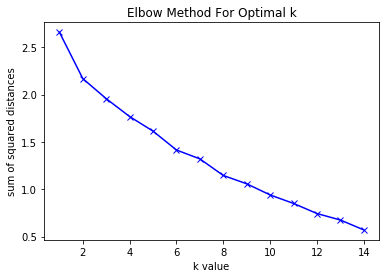

In [26]:
# Creating our plot:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k value')
plt.ylabel('sum of squared distances')
plt.title('Elbow Method For Optimal k')

plt.show()

In [27]:
# Setting our number of clusters to create to 6, based on the elbow method above:
kclusters = 6

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(leeds_grouped_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

leeds_cluster_merged = leeds_df

# merge leeds_cluster_merged with neighborhoods_venues_sorted to add latitude/longitude for each neighborhood
leeds_cluster_merged = leeds_cluster_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

leeds_cluster_merged.head()

,PostCode,Town,Neighborhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,LS1,Leeds,Leeds city centre,53.79674,-1.54754,2.0,Bar,Pub,Coffee Shop,Café,Indian Restaurant,Shopping Mall,Thai Restaurant,Music Venue,Beer Bar,Restaurant
1,LS2,Leeds,"Leeds city centre, Woodhouse",53.80123,-1.54597,2.0,Coffee Shop,Bar,Pub,Indian Restaurant,Café,Beer Bar,Restaurant,Thai Restaurant,Shopping Mall,Music Venue
2,LS3,Leeds,"Burley, Kirkstall, Woodhouse",53.80128,-1.55964,2.0,Coffee Shop,Café,Pub,Bar,Hotel,Nightclub,Italian Restaurant,Indian Restaurant,Thai Restaurant,Cocktail Bar
3,LS4,Leeds,"Burley, Kirkstall",53.80944,-1.58082,5.0,Supermarket,Coffee Shop,Grocery Store,Pub,Pizza Place,Café,Hotel,Ice Cream Shop,Cuban Restaurant,Shopping Plaza
4,LS5,Leeds,"Hawksworth, Kirkstall",53.81851,-1.60199,2.0,Pub,Coffee Shop,Gym / Fitness Center,Supermarket,Rugby Stadium,Shopping Plaza,Seafood Restaurant,Deli / Bodega,Furniture / Home Store,Bar


In [28]:
# We have one row which does not contain any data, so we must remove this before performing any further analysis:
# The specific row contained the area "LS24, Tadcaster", which is located far from Leeds:
leeds_cluster_merged.drop(index=23, axis=0, inplace=True)

# The row had to be removed so that the following change could be made (changing the row from floats to integers):
leeds_cluster_merged['Cluster Labels'] = leeds_cluster_merged['Cluster Labels'].astype(int)
leeds_cluster_merged.reset_index(drop=True)

,PostCode,Town,Neighborhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,LS1,Leeds,Leeds city centre,53.79674,-1.54754,2,Bar,Pub,Coffee Shop,Café,Indian Restaurant,Shopping Mall,Thai Restaurant,Music Venue,Beer Bar,Restaurant
1,LS2,Leeds,"Leeds city centre, Woodhouse",53.80123,-1.54597,2,Coffee Shop,Bar,Pub,Indian Restaurant,Café,Beer Bar,Restaurant,Thai Restaurant,Shopping Mall,Music Venue
2,LS3,Leeds,"Burley, Kirkstall, Woodhouse",53.80128,-1.55964,2,Coffee Shop,Café,Pub,Bar,Hotel,Nightclub,Italian Restaurant,Indian Restaurant,Thai Restaurant,Cocktail Bar
3,LS4,Leeds,"Burley, Kirkstall",53.80944,-1.58082,5,Supermarket,Coffee Shop,Grocery Store,Pub,Pizza Place,Café,Hotel,Ice Cream Shop,Cuban Restaurant,Shopping Plaza
4,LS5,Leeds,"Hawksworth, Kirkstall",53.81851,-1.60199,2,Pub,Coffee Shop,Gym / Fitness Center,Supermarket,Rugby Stadium,Shopping Plaza,Seafood Restaurant,Deli / Bodega,Furniture / Home Store,Bar
5,LS6,Leeds,"Beckett Park, Burley, Headingley, Hyde Park, M...",53.81928,-1.56704,2,Bar,Pub,Café,Pizza Place,Thai Restaurant,Restaurant,Hotel,Grocery Store,Coffee Shop,Ice Cream Shop
6,LS7,Leeds,"Beck Hill, Buslingthorpe, Chapel Allerton, Cha...",53.81828,-1.53971,5,Pub,Grocery Store,Fish & Chips Shop,Supermarket,Coffee Shop,Pizza Place,Dance Studio,Chinese Restaurant,Pharmacy,Farm
7,LS8,Leeds,"Fearnville, Gipton, Gledhow, Harehills, Oakwoo...",53.82445,-1.50926,5,Bar,Grocery Store,Café,Fast Food Restaurant,Restaurant,Middle Eastern Restaurant,Fish & Chips Shop,Sandwich Place,Garden,Supermarket
8,LS9,Leeds,"Burmantofts, Cross Green, East End Park, Gipto...",53.79928,-1.50803,5,Convenience Store,Pet Store,Bus Stop,Supermarket,Discount Store,Outdoor Supply Store,Sports Bar,Grocery Store,Train Station,Deli / Bodega
9,LS10,Leeds,"Belle Isle, Hunslet, Leeds city centre, Middle...",53.76162,-1.53123,4,Stadium,Convenience Store,Pub,Gym Pool,Gym / Fitness Center,Gym,Construction & Landscaping,Cricket Ground,Cuban Restaurant,Dance Studio


## Visualising Our Clusters <a name="cluster-vis"></a>

In [29]:
# Create one final map:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# Set colour scheme for the clusters using Numpy and Matplotlib:
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map:
markers_colors = []
for lat, lon, poi, cluster in zip(leeds_cluster_merged['latitude'], leeds_cluster_merged['longitude'], leeds_cluster_merged['Neighborhood'], leeds_cluster_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ', Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [30]:
# Cluster 0:

leeds_cluster_merged.loc[leeds_cluster_merged['Cluster Labels'] == 0, leeds_cluster_merged.columns[[0] + [1] + list(range(5, leeds_cluster_merged.shape[1]))]]

,PostCode,Town,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,LS13,Leeds,0,Supermarket,Coffee Shop,Train Station,Pub,Fast Food Restaurant,Gym / Fitness Center,Convenience Store,Cricket Ground,Cuban Restaurant,Dance Studio


In [31]:
# Cluster 1:

leeds_cluster_merged.loc[leeds_cluster_merged['Cluster Labels'] == 1, leeds_cluster_merged.columns[[0] + [1] + list(range(5, leeds_cluster_merged.shape[1]))]]

,PostCode,Town,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,LS18,Leeds,1,Pub,Coffee Shop,Pizza Place,Bar,Cricket Ground,Sandwich Place,Park,Café,English Restaurant,Fast Food Restaurant
18,LS19,Leeds,1,Pub,Lake,Cricket Ground,Fish & Chips Shop,Supermarket,Gas Station,Sports Club,Hotel,Gym,Golf Course
22,LS23,Wetherby,1,Pub,Bar,Convenience Store,Cricket Ground,Chinese Restaurant,Music Venue,Tea Room,Discount Store,Fast Food Restaurant,Farm
28,LS29,Ilkley,1,Pub,Train Station,Scenic Lookout,Trail,Gastropub,Construction & Landscaping,Convenience Store,Cricket Ground,Cuban Restaurant,Fast Food Restaurant


In [32]:
# Cluster 2:

leeds_cluster_merged.loc[leeds_cluster_merged['Cluster Labels'] == 2, leeds_cluster_merged.columns[[0] + [1] + list(range(5, leeds_cluster_merged.shape[1]))]]

,PostCode,Town,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,LS1,Leeds,2,Bar,Pub,Coffee Shop,Café,Indian Restaurant,Shopping Mall,Thai Restaurant,Music Venue,Beer Bar,Restaurant
1,LS2,Leeds,2,Coffee Shop,Bar,Pub,Indian Restaurant,Café,Beer Bar,Restaurant,Thai Restaurant,Shopping Mall,Music Venue
2,LS3,Leeds,2,Coffee Shop,Café,Pub,Bar,Hotel,Nightclub,Italian Restaurant,Indian Restaurant,Thai Restaurant,Cocktail Bar
4,LS5,Leeds,2,Pub,Coffee Shop,Gym / Fitness Center,Supermarket,Rugby Stadium,Shopping Plaza,Seafood Restaurant,Deli / Bodega,Furniture / Home Store,Bar
5,LS6,Leeds,2,Bar,Pub,Café,Pizza Place,Thai Restaurant,Restaurant,Hotel,Grocery Store,Coffee Shop,Ice Cream Shop
20,LS21,Otley,2,Park,Fish & Chips Shop,Garden Center,River,Café,Supermarket,Pub,Gastropub,Gas Station,Construction & Landscaping
26,LS27,Leeds,2,Discount Store,Bus Stop,Furniture / Home Store,Gym / Fitness Center,Pizza Place,Train Station,Pub,Fish & Chips Shop,Restaurant,Café


In [33]:
# Cluster 3:

leeds_cluster_merged.loc[leeds_cluster_merged['Cluster Labels'] == 3, leeds_cluster_merged.columns[[0] + [1] + list(range(5, leeds_cluster_merged.shape[1]))]]

,PostCode,Town,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,LS25,Leeds,3,Train Station,Skate Park,Wine Bar,Diner,Fast Food Restaurant,Farm,English Restaurant,Electronics Store,Discount Store,Department Store


In [34]:
# Cluster 4:

leeds_cluster_merged.loc[leeds_cluster_merged['Cluster Labels'] == 4, leeds_cluster_merged.columns[[0] + [1] + list(range(5, leeds_cluster_merged.shape[1]))]]

,PostCode,Town,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,LS10,Leeds,4,Stadium,Convenience Store,Pub,Gym Pool,Gym / Fitness Center,Gym,Construction & Landscaping,Cricket Ground,Cuban Restaurant,Dance Studio


In [35]:
# Cluster 5:

leeds_cluster_merged.loc[leeds_cluster_merged['Cluster Labels'] == 5, leeds_cluster_merged.columns[[0] + [1] + list(range(5, leeds_cluster_merged.shape[1]))]]

,PostCode,Town,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,LS4,Leeds,5,Supermarket,Coffee Shop,Grocery Store,Pub,Pizza Place,Café,Hotel,Ice Cream Shop,Cuban Restaurant,Shopping Plaza
6,LS7,Leeds,5,Pub,Grocery Store,Fish & Chips Shop,Supermarket,Coffee Shop,Pizza Place,Dance Studio,Chinese Restaurant,Pharmacy,Farm
7,LS8,Leeds,5,Bar,Grocery Store,Café,Fast Food Restaurant,Restaurant,Middle Eastern Restaurant,Fish & Chips Shop,Sandwich Place,Garden,Supermarket
8,LS9,Leeds,5,Convenience Store,Pet Store,Bus Stop,Supermarket,Discount Store,Outdoor Supply Store,Sports Bar,Grocery Store,Train Station,Deli / Bodega
10,LS11,Leeds,5,Grocery Store,Fast Food Restaurant,Park,Office,Deli / Bodega,Sandwich Place,Sporting Goods Shop,Supermarket,Discount Store,Farm
11,LS12,Leeds,5,Grocery Store,Pub,Supermarket,Gym / Fitness Center,Auto Dealership,Clothing Store,Shopping Plaza,Fast Food Restaurant,Furniture / Home Store,English Restaurant
13,LS14,Leeds,5,Bakery,Pharmacy,Discount Store,Supermarket,Sandwich Place,Fast Food Restaurant,Gym,Athletics & Sports,Dance Studio,Deli / Bodega
14,LS15,Leeds,5,Pub,Gastropub,Fast Food Restaurant,Fish & Chips Shop,Discount Store,Furniture / Home Store,Salon / Barbershop,Bakery,Butcher,Pizza Place
15,LS16,Leeds,5,Gym / Fitness Center,Gym,Grocery Store,Pub,Fast Food Restaurant,Indoor Play Area,Italian Restaurant,Gastropub,Shopping Mall,Cemetery
16,LS17,Leeds,5,Pub,Italian Restaurant,Grocery Store,Golf Course,Cuban Restaurant,Cricket Ground,Convenience Store,Dance Studio,Fish & Chips Shop,Deli / Bodega


## Concluding Remarks <a name="conclusion"></a>

### Location of bars

The first part of this analysis looked at the number of bars/pubs located within Leeds, leveraging the Foursquare Places API. This detailed a total number of __98__ unique venues located within 1 km of the centre point of each Leeds postcode. Displayed on a map; it was apparent that the majority of these venues were located closer to Leeds City Centre, specifically postcodes LS1, LS2 and LS3.

This is to be expected, as a developed city such as Leeds has a large number of people frequenting bars towards its centre. Higher foot-traffic by customers of course means a higher potential for earnings, assuming the bar is popular. The downsides to a more central location include higher rent payments and more competition with other established premises. Care should be taken if choosing to establish a bar towards the centre of Leeds and market research should be completed.

### Clustering Analysis

__K-Means clustering__ was utilised for this report, an unsupervised machine learning algorithm. It was able to effectively cluster the different areas around Leeds based upon the types of venues found within them.

Following the clustering analysis, we can view that the clusters labelled 0, 3 and 4 contained few instances of bars/pubs, owing to the fact they clustered differently from clusters 1, 2 and 5. Clusters 0, 3 and 4 also contained only one postcode in their cluster - potentially highlighting that starting up a bar in these areas would not be profitable.

__Specifically...__

* Cluster 0 featured one instance of a pub in the top ten venues, but most other venues included landmarks, sports clubs and train stations.
* Cluster 3 was similar, featuring mostly sports clubs, restaurants and some types of shops.
* Cluster 4 contained one postcode (LS10), containing more restaurants and shops as well as a stadium. Geographically, this is just south of the centre of Leeds and near to the Elland Road stadium - home of Leeds United Football Club.

__Clusters 1, 2 & 5__

Clusters 1, 2 and 5 contained the most number of postcodes compared to the others. The majority of these feature some form of pub/bar as the most popular venue within that postcode.

Cluster 2 contains most of the postcodes that are considered "central Leeds", which coincides with our findings from plotting the locations of bars on the map of Leeds. Cluster 1 features many of the postcodes that contain a high number of bars, also.

Cluster 5 includes some central locations, as well as capturing many establishments which are located along the outskirts of the main city and containing rural villages. 

An interesting observation within these clusters is that bars are much more common the closer to the city centre the postcodes are. This may be owed to the fact that people tend to visit more than one location when they go into the city to have some drinks. Postcodes which surround the more central locations tend to be to be pubs, which are traditionally more homely and people spend longer there.

In all clusters created, there are no instances of a speakeasy appearing in the top ten most common venues for any postcode. This may highlight a gap in the market for a more laid-back venue to open within the city of Leeds or its outskirts.

### Where would be suitable?

The above analysis has helped to elucidate an appropriate location to open a new bar within the city of Leeds. The entire area, including every postcode, has been included in the analysis.

I would recommend that the business owner consider setting up their new venture in any of the postcodes outlined in clusters __1, 2 or 5__. It may be pertinent to consider opening a bar if a more central location is considered, whereas a pub may be much more suitable for a more rural location. Depending on the decision, appropriate market research of these areas combined with this clustering analysis should further highlight an optimal position in which to open a new business.

Lastly, this analysis has highlighted that there are few speakeasies located within the city of Leeds, so this may be a profitable venture if the business owner is looking to open a venue which is less common.